# Amazon Fine Food Reviews Analysis - Using Naive Bayes


# [1.1] Introduction
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


# [1.2] Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2) using Naive Bayes algorithm.




## [1.3] Loading the data

In order to load the data, have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\shashidhar\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score > 3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [1.4] Data Preprocessing

## [1.4.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## 1.4.2  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'a', 'y', 'me', 's', 'while', 'ma', 'into', 'weren', 'because', 'then', 'hasn', 'you', 'm', "hadn't", 'to', 'below', "didn't", 'shan', 'if', 'we', 'during', 'can', 'too', 'ain', 'off', 'had', 'wouldn', "you'll", 'out', 'don', 'them', 'but', 'be', 'when', 'have', 'or', 'most', 'as', 'he', 'each', 'my', 'above', 'under', 'are', 'few', 'didn', 'am', 'd', 'with', 'such', 'aren', 'between', "shouldn't", 'over', 't', 'yourself', 'their', 'haven', "mustn't", 'just', 'only', 'isn', 'has', 'of', 'hadn', 'being', 'do', 'an', 'on', 'did', 'who', 'so', 'nor', 'is', 'should', 'whom', 'and', 'some', 'mustn', 'before', 'mightn', 'not', 'won', 'which', "don't", 'now', "aren't", 'there', 'all', "won't", 'theirs', 'for', 'once', "you're", 'does', 'hers', 'any', 'the', 'further', 'themselves', 'that', 'no', 'o', 'ourselves', 'what', 'your', 'couldn', 'here', "couldn't", 'yours', "needn't", "it's", 'yourselves', 'was', "should've", 'its', 'in', 'his', 'very', 'about', "hasn't", 're', 'been', 'him', 'by',

In [17]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [09:34<00:00, 633.84it/s]


In [18]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [19]:
final.shape

(364171, 13)

## [1.5] Data Sampling

In [23]:
# sorting based on time
#final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final.sort_values(by = "Time")

In [24]:
#picked 100k sample data
final_100k = final.iloc[:100000,:]

# [1.6] Naive Bayes analysis for BoW, Tfidf, Avg_W2V and Tfidf_W2V

In [25]:
# Fuction to compute alpha values for different methods
def find_hyper_param(X_train, y_train):
    # creating odd list of K for KNN
    #myList = list(range(0,50))
    params = [0.00001, 0.0001, 0.001, 0.01, 1, 10, 100]

    # empty list that will hold cv scores
    cv_scores = []
    
    # empty list to hold alpha values
    alpha_values = []
    
    j=0
    # perform 10-fold cross validation
    for a in params:
        nb = BernoulliNB(alpha=a)
        scores = cross_val_score(nb, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
        alpha_values.append(a)
        print('For Alpha = ', a, ' - Accuracy Score = ', cv_scores[j])
        j+=1
    
    alpha_optimal = alpha_values[cv_scores.index(max(cv_scores))]
    plt.plot(alpha_values,cv_scores,'-o')
    plt.xlabel('Alpha Values')
    plt.ylabel('CV Scores')
    plt.title('Alpha Values vs CV Scores')
    plt.show()
    return alpha_optimal

In [26]:
# X input for the model
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

# Y input or Class label for the model
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of X: (100000,)
shape of y: (100000,)


In [27]:
final_100k.head(2)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08 00:00:00,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25 00:00:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...


In [28]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape)
print(x_test.shape)
print(y_test.shape)

(70000,) (70000,)
(30000,)
(30000,)


### [1.6.1] Naive Bayes Analysis - BoW

In [29]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bag_of_words = CountVectorizer()
X_train = bag_of_words.fit_transform(X_train)
X_train

<70000x31616 sparse matrix of type '<class 'numpy.int64'>'
	with 2105885 stored elements in Compressed Sparse Row format>

In [30]:
# Test Vectorizor
x_test = bag_of_words.transform(x_test)
x_test.shape

(30000, 31616)

C:\Users\shashidhar\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


For Alpha =  1e-05  - Accuracy Score =  0.8951000256725953
For Alpha =  0.0001  - Accuracy Score =  0.8961428746620994
For Alpha =  0.001  - Accuracy Score =  0.8971714277311953
For Alpha =  0.01  - Accuracy Score =  0.8965857603793012
For Alpha =  1  - Accuracy Score =  0.8814572480023344
For Alpha =  10  - Accuracy Score =  0.8723285907930032
For Alpha =  100  - Accuracy Score =  0.8769857173638484


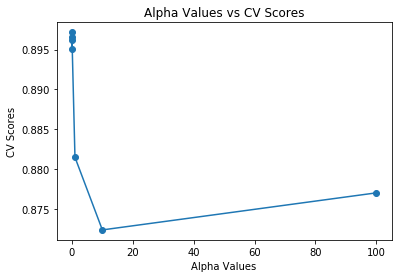

Optimal alpha is :  0.001


In [31]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation

# To choose optimal alpha using 10 fold CV
alpha_optimal = find_hyper_param(X_train, y_train)
print("Optimal alpha is : ",alpha_optimal)

In [32]:
# instantiated Naive Bayes model with best alpha value
nb_optimal_k = BernoulliNB(alpha=alpha_optimal)

# fitting the model
nb_optimal_k.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = nb_optimal_k.predict(x_test)

#### Top 10 features in each class - BoW

In [33]:
neg_class_prob_sorted_bow = nb_optimal_k.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted_bow = nb_optimal_k.feature_log_prob_[1, :].argsort()

print('Top 10 features in negative class are as below :')
print(np.take(bag_of_words.get_feature_names(), neg_class_prob_sorted_bow[:10]))
print('\nTop 10 features in positive class are as below :')
print(np.take(bag_of_words.get_feature_names(), pos_class_prob_sorted_bow[:10]))

Top 10 features in negative class are as below :
['lightpost' 'nautic' 'nauseau' 'naught' 'naturesway' 'naturespath'
 'natureon' 'naturefresh' 'naturapath' 'naturalsweet']

Top 10 features in positive class are as below :
['quarrel' 'ifeel' 'nds' 'ndigest' 'carboxymethylcellulos'
 'trichlorosucros' 'trichloroethylen' 'boorish' 'tribun' 'ightweight']


In [34]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score

accuracy_score_bow = np.round((accuracy_score(y_test, pred)*100),decimals = 2)
f1_score_bow = np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2)
recall_bow = np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2)
precision_bow = np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2)
classification_report_bow = classification_report(y_test,pred)

print('The Accuracy score with alpha  = ', alpha_optimal, ' is ', accuracy_score_bow)
print('The F1 Score with alpha        = ', alpha_optimal, ' is ', f1_score_bow)
print('The Precision score with alpha = ', alpha_optimal, ' is ', precision_bow)
print('The Recall score with alpha    = ', alpha_optimal, ' is ', recall_bow)
print('\nClassification report for Naive Bayes algorithm with optimal alpha is as below\n\n ', classification_report_bow)

The Accuracy score with alpha  =  0.001  is  90.29
The F1 Score with alpha        =  0.001  is  76.16
The Precision score with alpha =  0.001  is  77.67
The Recall score with alpha    =  0.001  is  74.88

Classification report for Naive Bayes algorithm with optimal alpha is as below

               precision    recall  f1-score   support

          0       0.62      0.54      0.58      3663
          1       0.94      0.95      0.95     26337

avg / total       0.90      0.90      0.90     30000



Text(0.5,15,'Predicted label')

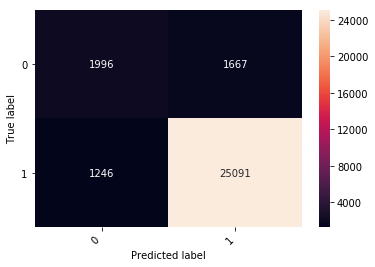

In [35]:
plt.figure()
confusion_matrix_Plot = confusion_matrix(y_test,pred)
heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Observations on Naive Bayes using BoW :
    1. Optimal alpha got by CV is 0.001
    2. Accuracy during training is 89.71% and testing is 90.29%
    3. F1 score, 
           Positive reviews -> 95% 
           Negative reviews -> 58%
           Total reviews    -> 90%
    4. From the confusion matrix with heat map, for NEGATIVE REVIEWS it is observed as below,
           Classified correctly -> 55%
           Misclassified        -> 45%
    5. From the confusion matrix with heat map, for POSITIVE REVIEWS it is observed as below,
           Classified correctly -> 95%
           Misclassified        -> 5%

### [1.6.2] Naive Bayes analysis - tfidf

In [37]:
# X input for the model
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

# Y input or Class label for the model
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of X: (100000,)
shape of y: (100000,)


In [38]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape)
print(x_test.shape)
print(y_test.shape)

(70000,) (70000,)
(30000,)
(30000,)


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)

In [40]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
print(x_test.shape)

(30000, 934067)


For Alpha =  1e-05  - Accuracy Score =  0.8973285950827993
For Alpha =  0.0001  - Accuracy Score =  0.9014285849227408
For Alpha =  0.001  - Accuracy Score =  0.9031715339072907
For Alpha =  0.01  - Accuracy Score =  0.8849429419242
For Alpha =  1  - Accuracy Score =  0.8573999702746349
For Alpha =  10  - Accuracy Score =  0.8769571500163267
For Alpha =  100  - Accuracy Score =  0.8770285745067057


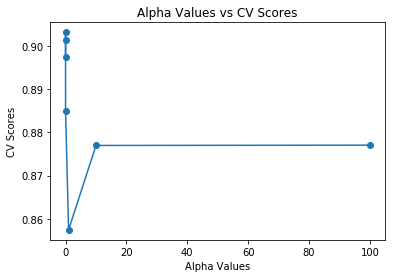

Optimal alpha value for Tfidf is :  0.001


In [42]:
alpha_optimal_tfidf = find_hyper_param(X_train, y_train)
print('Optimal alpha value for Tfidf is : ', alpha_optimal_tfidf)

In [43]:
# instantiated Naive Bayes model with best alpha
nb_optimal_alpha = BernoulliNB(alpha=alpha_optimal_tfidf)

# fitting the model
nb_optimal_alpha.fit(X_train, y_train)

# predict the response
pred = nb_optimal_alpha.predict(x_test)

#### Top 10 Features for each class - Tfidf

In [44]:
neg_class_prob_sorted_tfidf = nb_optimal_alpha.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted_tfidf = nb_optimal_alpha.feature_log_prob_[1, :].argsort()

print('Top 10 features in negative class are as below :')
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted_tfidf[:10]))
print('\nTop 10 features in positive class are as below :')
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted_tfidf[:10]))

Top 10 features in negative class are as below :
['çay' 'mani allow' 'mani almond' 'mani almost' 'tasti pile' 'tasti piec'
 'tasti pickiest' 'mani alway' 'mani amazon' 'mani allergi']

Top 10 features in positive class are as below :
['instead descript' 'foot white' 'starchi sweet' 'categori item'
 'footbal eat' 'stare get' 'stare huge' 'nectar whop' 'nectar websit'
 'stare puzzl']


In [45]:
accuracy_score_tfidf = np.round((accuracy_score(y_test, pred)*100),decimals = 2)
f1_score_tfidf = np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2)
recall_tfidf = np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2)
precision_tfidf = np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2)
classification_report_tfidf = classification_report(y_test,pred)

print('The Accuracy score with alpha  = ', alpha_optimal, ' is ', accuracy_score_tfidf)
print('The F1 Score with alpha        = ', alpha_optimal, ' is ', f1_score_tfidf)
print('The Precision score with alpha = ', alpha_optimal, ' is ', precision_tfidf)
print('The Recall score with alpha    = ', alpha_optimal, ' is ', recall_tfidf)
print('\nClassification report for Naive Bayes algorithm with optimal alpha is as below\n\n ', classification_report_tfidf)

The Accuracy score with alpha  =  0.001  is  90.28
The F1 Score with alpha        =  0.001  is  66.74
The Precision score with alpha =  0.001  is  87.21
The Recall score with alpha    =  0.001  is  62.26

Classification report for Naive Bayes algorithm with optimal alpha is as below

               precision    recall  f1-score   support

          0       0.84      0.25      0.39      3663
          1       0.91      0.99      0.95     26337

avg / total       0.90      0.90      0.88     30000



Text(0.5,15,'Predicted label')

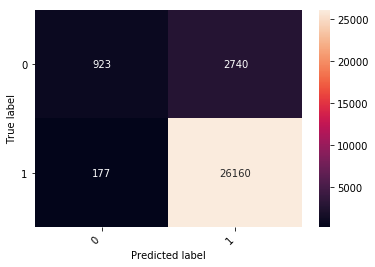

In [46]:
plt.figure()
confusion_matrix_Plot = confusion_matrix(y_test,pred)
heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Observations on Naive Bayes using Tfidf :
    1. Optimal alpha got by CV is 0.001
    2. Accuracy during training is 90.31 and testing is 90.28
    3. F1 Score 
          Positive reviews -> 95%
          Negative reviwes -> 39%
          Total reviews    -> 88%
       F1 Score for negative reviews is very low.
    4. From the confusion matrix with heat map, observed around 75% negative reviews are misclassified.
          Classified correctly -> 25%
          Misclassified        -> 75%
    5. From the confusion matrix with heat map, observed around 0.6% positive reviews are misclassified.
          Classified correctly -> 99.4%
          Misclassified        -> 0.6%

### [1.6.3] Naive Bayes analysis - Avg Word2Vec

In [48]:
# X input for the model
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

# Y input or Class label for the model
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of X: (100000,)
shape of y: (100000,)


In [49]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape)
print(x_test.shape)
print(y_test.shape)

(70000,) (70000,)
(30000,)
(30000,)


In [50]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
#for sent in final_40k['Text'].values:
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [51]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [52]:
w2v = w2v_model[w2v_model.wv.vocab]

In [53]:
w2v.shape

(10736, 50)

In [54]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [55]:
w2v_model=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [56]:
w2v = w2v_model[w2v_model.wv.vocab]

In [57]:
w2v.shape

(7370, 50)

In [58]:
# compute average word2vec for each review.
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.nan_to_num(sent_vectors)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [59]:
# compute average word2vec for each review.

sent_vectors_test = [];
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.nan_to_num(sent_vectors_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


For Alpha =  1e-05  - Accuracy Score =  0.8495859457067102
For Alpha =  0.0001  - Accuracy Score =  0.8495859457067102
For Alpha =  0.001  - Accuracy Score =  0.8495859457067102
For Alpha =  0.01  - Accuracy Score =  0.8495859457067102
For Alpha =  1  - Accuracy Score =  0.8495716640740574
For Alpha =  10  - Accuracy Score =  0.8497431048932995
For Alpha =  100  - Accuracy Score =  0.8508002783682274


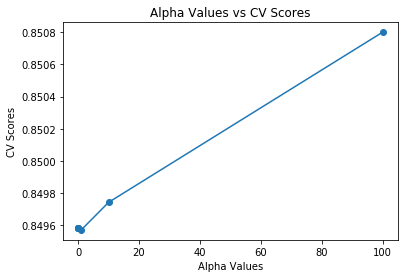

Optimal alpha for the Average W2V is :  100


In [60]:
X_train = sent_vectors
X_test = sent_vectors_test
best_alpha_avgw2v = find_hyper_param(X_train, y_train)
print('Optimal alpha for the Average W2V is : ', best_alpha_avgw2v)

In [61]:
# instantiated Naive Bayes model with best alpha
nb_optimal_alpha_Avg_w2v = BernoulliNB(alpha=best_alpha_avgw2v)

# fitting the model
nb_optimal_alpha_Avg_w2v.fit(X_train, y_train)

# predict the response
pred = nb_optimal_alpha_Avg_w2v.predict(X_test)

In [62]:
accuracy_score_avg_w2v = np.round((accuracy_score(y_test, pred)*100),decimals = 2)
f1_score_avg_w2v = np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2)
recall_avg_w2v = np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2)
precision_avg_w2v = np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2)
classification_report_avg_w2v = classification_report(y_test,pred)

print('The Accuracy score with alpha  = ', best_alpha_avgw2v, ' is ', accuracy_score_avg_w2v)
print('The F1 Score with alpha        = ', best_alpha_avgw2v, ' is ', f1_score_avg_w2v)
print('The Precision score with alpha = ', best_alpha_avgw2v, ' is ', precision_avg_w2v)
print('The Recall score with alpha    = ', best_alpha_avgw2v, ' is ', recall_avg_w2v)
print('\nClassification report for Naive Bayes algorithm with optimal alpha is as below\n\n ', classification_report_avg_w2v)

The Accuracy score with alpha  =  100  is  84.95
The F1 Score with alpha        =  100  is  65.26
The Precision score with alpha =  100  is  65.1
The Recall score with alpha    =  100  is  65.42

Classification report for Naive Bayes algorithm with optimal alpha is as below

               precision    recall  f1-score   support

          0       0.39      0.40      0.39      3663
          1       0.92      0.91      0.91     26337

avg / total       0.85      0.85      0.85     30000



Text(0.5,15,'Predicted label')

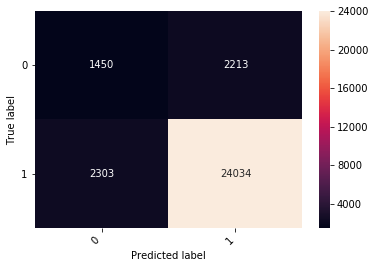

In [63]:
plt.figure()
confusion_matrix_Plot = confusion_matrix(y_test,pred)
heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Observations on Naive Bayes using Avg W2V :
    1. Optimal alpha got by CV is 100
    2. Accuracy during training is 85% and during testing is 84.95%
    3. F1 score,
          Positive reviews -> 91%
          Negative reviews -> 39%
          Total reviews    -> 85%
       F1 Score for negative reviews is very low.
    4. From the confusion matrix with heat map, for NEGATIVE reviews it is observed as below,
          Classified correctly  -> 40%
          Misclassied           -> 60%
          Misclassification rate is high for negative reviews.
    5. From the confusion matrix with heat map, for POSITIVE reviews it is observed as below,
          Classified correctly  -> 91.3%
          Misclassified         -> 8.7%
          Correctly classification rate is high for positive reviews.

### [1.6.4] Naive Bayes Analysis - Tfidf Weighted W2V

In [64]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [65]:
print("Length of the TFTDF vector is : ", len(tfidf_sent_vectors))
X_train = tfidf_sent_vectors

Length of the TFTDF vector is :  70000


In [66]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

In [67]:
print("Length of tfidf vector : ", len(tfidf_sent_vectors_test))
x_test = tfidf_sent_vectors_test

Length of tfidf vector :  30000


In [68]:
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)

For Alpha =  1e-05  - Accuracy Score =  0.8770285745067057
For Alpha =  0.0001  - Accuracy Score =  0.8770285745067057
For Alpha =  0.001  - Accuracy Score =  0.8770285745067057
For Alpha =  0.01  - Accuracy Score =  0.8770285745067057
For Alpha =  1  - Accuracy Score =  0.8770285745067057
For Alpha =  10  - Accuracy Score =  0.8770285745067057
For Alpha =  100  - Accuracy Score =  0.8770285745067057


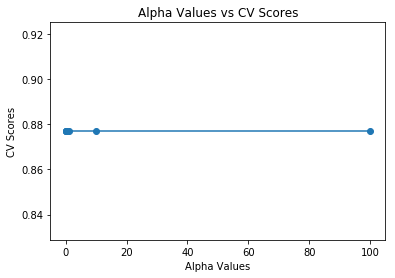

Optimal alpha for Tfidf weighted w2v is :  1e-05


In [69]:
best_alpha_tfidf_w2v = find_hyper_param(X_train, y_train)
print('Optimal alpha for Tfidf weighted w2v is : ', best_alpha_tfidf_w2v)

In [70]:
# instantiated Naive Bayes model with best alpha
nb_optimal_alpha_tfidf_w2v = BernoulliNB(alpha=best_alpha_tfidf_w2v)

# fitting the model
nb_optimal_alpha_tfidf_w2v.fit(X_train, y_train)

# predict the response
pred = nb_optimal_alpha_tfidf_w2v.predict(X_test)

In [71]:
accuracy_score_tfidf_w2v = np.round((accuracy_score(y_test, pred)*100),decimals = 2)
f1_score_tfidf_w2v = np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2)
recall_tfidf_w2v = np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2)
precision_tfidf_w2v = np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2)
classification_report_tfidf_w2v = classification_report(y_test,pred)

print('The Accuracy score with alpha  = ', best_alpha_tfidf_w2v, ' is ', accuracy_score_tfidf_w2v)
print('The F1 Score with alpha        = ', best_alpha_tfidf_w2v, ' is ', f1_score_tfidf_w2v)
print('The Precision score with alpha = ', best_alpha_tfidf_w2v, ' is ', precision_tfidf_w2v)
print('The Recall score with alpha    = ', best_alpha_tfidf_w2v, ' is ', recall_tfidf_w2v)
print('\nClassification report for Naive Bayes algorithm with optimal alpha is as below\n\n ', classification_report_tfidf_w2v)

C:\Users\shashidhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\shashidhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\shashidhar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The Accuracy score with alpha  =  1e-05  is  12.21
The F1 Score with alpha        =  1e-05  is  10.88
The Precision score with alpha =  1e-05  is  6.1
The Recall score with alpha    =  1e-05  is  50.0

Classification report for Naive Bayes algorithm with optimal alpha is as below

               precision    recall  f1-score   support

          0       0.12      1.00      0.22      3663
          1       0.00      0.00      0.00     26337

avg / total       0.01      0.12      0.03     30000



Text(0.5,15,'Predicted label')

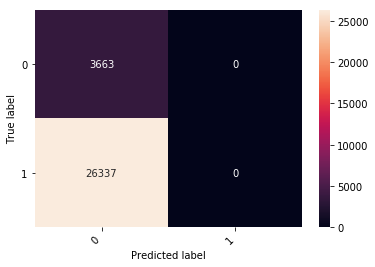

In [72]:
plt.figure()
confusion_matrix_Plot = confusion_matrix(y_test,pred)
heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Observations on Naive Bayes using Tfidf W2V :
    1. Optimal alpha got by CV is 1e-05
    2. Accuracy during training is 87.7% and during testing is 12.21%.
    3. F1 score,
           Positive reviews -> 0%
           Negative reviews -> 0.22%
           Total reviews    -> 0.3%
           F1 score for positive reviews is zero and for negative reviews is very low.
    3. From the confusion matrix with heat map, it is observed that 100% of negative reviews are CLASSIFIED CORRECTLY.
           Classified correctly -> 100%
           Misclassified        -> 0%
    4. From the confusion matrix with heat map, it is observed that 100% of positive reviews are MISCLASSIFIED.
           Classified correctly -> 0%
           Misclassified        -> 100%

## [1.7] Conclusions :

1. Using BOW, TFIDF and AVG TFIDF methods there is no much change in accuracy during training and testing phase.                
   BOW     :  
           Accuracy during Training : 89.71%                                                                                
           Accuracy during Testing  : 90.29%                                                                                
   TFIDF   :  
           Accuracy during Training : 90.31%                                                                                
           Accuracy during Testing  : 90.28%                                                                                
   AVG W2V :  
           Accuracy during Training : 85%                                                                                   
           Accuracy during Testing  : 84.95%                                                                                
                                                                                                                                                                                                                                                                 
2. Using TFIDF W2V method overfitted as Accuracy during Training is high and during Testing is very low.                        
   Accuracy during Training : 87.7%                                                                                             
   Accuracy during Testing  : 12.21%                                                                                            
   Hence TFIDF W2V method is not good method for Amazon food reviews                                                            
                                                                                                                                                                                                                                                                 
2. BoW method resulted in good F1 score than other methods,                                                                     
   Positive reviews F1 score : 95%                                                                                              
   Negative reviews F1 score : 58%                                                                                              
   All reviews F1 score      : 90%                                                                                              
                                                                                                                                                                                                                                                                 
3. BOW method resulted in lower misclassification rate than other methods,                                                      
   Misclassified negative reviews : 45% (55% classified correctly)                                                              
   Misclassified positive reviews : 5% (95% classified correctly)                                                               
                                                                                                                                                                                                                                                                 
4. Order of the methods considering overall performace is as follows,                                                           
   First best method      : BOW                                                                                                 
   Second best method     : TFIDF                                                                                               
   Third best method      : AVG W2V                                                                                             
   Worst performed method : TFIDF W2V                                                                                           